In [1]:
import nibabel as nib
import numpy as np
from nibabel import processing 
import matplotlib.pyplot as plt

# Cammoun parcelation

## Parcellate BMI map

In [2]:
from netneurotools import datasets as nntdatasets
from neuromaps import datasets as nmdatasets
from neuromaps.parcellate import Parcellater
import pandas as pd
import neuromaps

cammoun = nntdatasets.fetch_cammoun2012(version="MNI152NLin2009aSym")
info = pd.read_csv(cammoun['info'])
labels = info.query('scale=="scale125"')['label']  # or might be "labels"

BMI = neuromaps.images.load_nifti('/dagher/dagher9/filip/DBM/HCP_DBM_Slvl/beta_0003.nii')
parc = Parcellater(cammoun['scale125'], 'mni152')  # assuming mymap is in mni152 space
BMI_parc = parc.fit_transform(BMI, 'mni152')
#BMI_parc=np.delete(BMI_parc, -1)

np.savetxt('/dagher/dagher9/filip/BMI_vals_125.txt',BMI_parc, delimiter='\t',fmt='%f')

/dagher/dagher12/filip/software/miniconda3py/envs/py3/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## Transform to surface space for further plotting in MATLAB

In [6]:
from neuromaps.datasets import fetch_annotation
from neuromaps import transforms

fsavg = transforms.mni152_to_fsaverage(BMI, '164k')
fsavg_lh, fsavg_rh = fsavg

np.savetxt(('/dagher/dagher11/filip/Obesity_maps/data/BMI_DBM_LH.csv'), fsavg_lh.agg_data())
np.savetxt(('/dagher/dagher11/filip/Obesity_maps/data/BMI_DBM_RH.csv'), fsavg_rh.agg_data())

In [11]:
BMIDBM_10k = transforms.mni152_to_fsaverage(BMI, '10k')

# Correlations

## Run correlations with neuromaps

In [8]:
import nibabel as nib
from neuromaps.datasets import available_annotations
from neuromaps import datasets
from neuromaps.resampling import resample_images
from neuromaps import parcellate
from neuromaps import datasets, images, nulls, resampling, plotting
from neuromaps.datasets import fetch_annotation
from neuromaps import transforms
from neuromaps.stats import compare_images

In [14]:
for annotation in available_annotations():
    if annotation[2]!='MNI152':
        try:
            print(annotation)
            brain_map=datasets.fetch_annotation(source=annotation[0], desc=annotation[1])
            BMI_res, brain_map_res = resample_images(src=BMIDBM_10k, trg=brain_map, src_space='fsaverage', 
                                                     trg_space=annotation[2], method='linear', 
                                                     resampling='transform_to_src')
            rotated = nulls.alexander_bloch(BMI_res, atlas='fsaverage', density='10k', n_perm=1000, seed=1234)
            corr = compare_images(BMI_res, brain_map_res, metric='pearsonr', nulls=rotated)
            print(corr)
        except:
            pass

('abagen', 'genepc1', 'fsaverage', '10k')
(-0.168299600481987, 0.3726273726273726)
('hcps1200', 'megalpha', 'fsLR', '4k')
(-0.288351446390152, 0.2627372627372627)
('hcps1200', 'megbeta', 'fsLR', '4k')
(0.22695554792881012, 0.35064935064935066)
('hcps1200', 'megdelta', 'fsLR', '4k')
(0.10867272317409515, 0.7072927072927073)
('hcps1200', 'meggamma1', 'fsLR', '4k')
(0.26927852630615234, 0.1968031968031968)
('hcps1200', 'meggamma2', 'fsLR', '4k')
(0.027480393648147583, 0.916083916083916)
('hcps1200', 'megtheta', 'fsLR', '4k')
(0.37139663100242615, 0.014985014985014986)
('hcps1200', 'megtimescale', 'fsLR', '4k')
(0.09316320717334747, 0.7292707292707292)
('hcps1200', 'myelinmap', 'fsLR', '32k')
(-0.06291040033102036, 0.5944055944055944)
('hcps1200', 'thickness', 'fsLR', '32k')
(0.009287900291383266, 0.965034965034965)
('hill2010', 'devexp', 'fsLR', '164k')
('hill2010', 'evoexp', 'fsLR', '164k')
('margulies2016', 'fcgradient01', 'fsLR', '32k')
(0.2164190411567688, 0.07792207792207792)
('margu

# Same using brainsmash - different because we are including subcortical structures

## Run brainsmash on BMI map - create surrogate maps

In [211]:
import pandas as pd
from brainsmash.mapgen.base import Base

brain_map_file = "/dagher/dagher9/filip/BMI_vals_125.txt" 
dist_mat_file = "/dagher/dagher11/filip/Downloads/Euc_dist125.txt"
base = Base(x=brain_map_file, D=dist_mat_file)

surrogates = base(n=1000)
spin1000=pd.DataFrame(data=surrogates)
spin1000.to_csv("/dagher/dagher9/filip/BMI_1000spin_smash.csv",sep=',',index=False)

## Parcellate all other maps and calculate corrs based on surrogate maps

In [212]:
from neuromaps.datasets import available_annotations
from neuromaps import datasets, images, nulls, resampling, plotting
from neuromaps.datasets import fetch_annotation

for annotation in available_annotations():
    if annotation[2]=='MNI152':
        print(annotation)
        brain_map=datasets.fetch_annotation(source=annotation[0], desc=annotation[1])
        brain_map_parc=parc.fit_transform(brain_map, annotation[2])
        main_corr=np.corrcoef(BMI_parc, brain_map_parc)[1,0]
        print(main_corr)
        corrs=list()
        for spin in range(1000):
            corrs.append(np.corrcoef(surrogates[spin], brain_map_parc)[1,0])
        print(sum(i > abs(main_corr) for i in np.absolute(corrs))/1001)
        

('aghourian2017', 'feobv', 'MNI152', '1mm')
-0.03114170003300519
0.8041958041958042
('alarkurtti2015', 'raclopride', 'MNI152', '3mm')
-0.03603109639730396
0.7182817182817183
('bedard2019', 'feobv', 'MNI152', '1mm')
-0.09287589548568777
0.47952047952047955
('beliveau2017', 'az10419369', 'MNI152', '1mm')
-0.051857481134645486
0.6063936063936064
('beliveau2017', 'cimbi36', 'MNI152', '1mm')
-0.022605833480744054
0.8411588411588412
('beliveau2017', 'cumi101', 'MNI152', '1mm')
-0.24565984719429343
0.15684315684315683
('beliveau2017', 'dasb', 'MNI152', '1mm')
-0.3216692064322344
0.03296703296703297
('beliveau2017', 'sb207145', 'MNI152', '1mm')
-0.14879312656467167
0.27472527472527475
('ding2010', 'mrb', 'MNI152', '1mm')
0.1807770943789401
0.2887112887112887
('dubois2015', 'abp688', 'MNI152', '1mm')
0.1598532746318848
0.24575424575424576
('dukart2018', 'flumazenil', 'MNI152', '3mm')
-0.08912409254622046
0.4035964035964036
('dukart2018', 'fpcit', 'MNI152', '3mm')
-0.16560989717605196
0.34465534

/dagher/dagher11/filip/Software/miniconda/envs/brainsmash/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

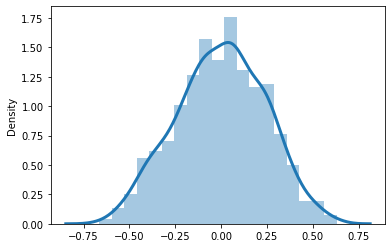

In [224]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
#plt.hist(corrs, color = 'blue', edgecolor = 'black',
#         bins = int(180/5))

sns.distplot(corrs, hist = True, kde = True,
                 kde_kws = {'shade': False, 'linewidth': 3})

#################################################################################################################

# Voxelwise - did not work

In [28]:
def show_slices(slices):

   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))

   for i, slice in enumerate(slices):

       axes[i].imshow(slice.T, cmap="gray", origin="lower")

## Load and mask correlation image

In [100]:
corr_img = nib.load('/home/bic/fmorys/neuromaps-data/annotations/rosaneto/abp688/MNI152/source-rosaneto_desc-abp688_space-MNI152_res-1mm_feature.nii.gz')

corr_img_data = corr_img.get_fdata()

### Create GM mask for multiplying

In [110]:
GM_mask = nib.load('/dagher/dagher11/filip/Software/spm12/toolbox/cat12/templates_MNI152NLin2009cAsym/vol0000.nii')

GM_mask=processing.resample_from_to(GM_mask, corr_img)
GM_mask_data = GM_mask.get_fdata()
GM_mask_data[GM_mask_data<=0.8]=0 # threshold at 0.3 - looks like a good GM mask
GM_mask_data[GM_mask_data>0.8]=1

corr_img_data_masked=np.multiply(GM_mask_data,corr_img_data)

### Load and reslice mask to fit correlation image

In [106]:
#mask = nib.load('/dagher/dagher9/filip/HCP_DBM_Slvl/rbrainmask_T1_ero.nii')

#mask_res=processing.resample_from_to(mask, corr_img)
#mask_res_data = mask_res.get_fdata()

#corr_img_data_masked=np.multiply(mask_res_data,corr_img_data)

In [111]:
corr_img_nonzero = np.argwhere(corr_img_data_masked != 0) # coordinates of non-zero voxels

corr_img_vals=list() # Values of non-zero voxels

for nonzer in corr_img_nonzero:
    corr_img_vals.append(corr_img_data_masked[nonzer[0], nonzer[1], nonzer[2]])
    
np.savetxt('/dagher/dagher9/filip/img_coords.txt',corr_img_nonzero, delimiter='\t',fmt='%i')
np.savetxt('/dagher/dagher9/filip/img_vals.txt',corr_img_vals, delimiter='\t',fmt='%f')

# Load BMI images, reslice it, mask it, get voxel coords and values

In [68]:
BMI_img = nib.load('/dagher/dagher9/filip/HCP_DBM_Slvl/beta_0003.nii')

BMI_img_data = BMI_img.get_fdata()

### Because there are some zeros within the brain, I am setting them first to 100,  then masking the brain and removing all voxels that are zero, and then setting voxesl = 100 back to zero

In [69]:
BMI_res=processing.resample_from_to(BMI_img, corr_img)
BMI_res_data = BMI_res.get_fdata()

for zer_coord in np.argwhere(BMI_res_data == 0):
    BMI_res_data[zer_coord[0], zer_coord[1], zer_coord[2]]=100

BMI_masked=np.multiply(BMI_res_data, GM_mask_data)

for hundred_coord in np.argwhere(BMI_masked == 100):
    BMI_masked[hundred_coord[0], hundred_coord[1], hundred_coord[2]]=0

In [70]:
BMI_nonzero = np.argwhere(BMI_masked != 0) # coordinates of non-zero voxels

BMI_vals=list() # Values of non-zero voxels

for nonzer in BMI_nonzero:
    BMI_vals.append(BMI_masked[nonzer[0], nonzer[1], nonzer[2]])
    
np.savetxt('/dagher/dagher11/filip/Obesity_maps/data/BMI_coords.txt',BMI_nonzero, delimiter='\t',fmt='%f')
np.savetxt('/dagher/dagher11/filip/Obesity_maps/data/BMI_vals.txt',BMI_vals, delimiter='\t',fmt='%f')

# Brainsmash

In [112]:
from brainsmash.workbench.geo import volume
#reload(brainsmash.workbench.geo)

coord_file = "/dagher/dagher9/filip/img_coords.txt"
output_dir = "/dagher/dagher9/filip/"

filenames = volume(coord_file, output_dir)

loading voxels coordinates from /dagher/dagher9/filip/img_coords.txt
file contains 98167 voxels
saving memory-mapped distance matrix files to /dagher/dagher9/filip/
/dagher/dagher9/filip/distmat.npy
/dagher/dagher9/filip/index.npy
98167


KeyboardInterrupt: 

In [ ]:
from brainsmash.mapgen.eval import sampled_fit

brain_map = "/some_path_to/brain_map.txt"

# These are three of the key parameters affecting the variogram fit
kwargs = {'ns': 500,
          'knn': 1500,
          'pv': 70
          }

# Running this command will generate a matplotlib figure
sampled_fit(brain_map, filenames['D'], filenames['index'], nsurr=10, **kwargs)

In [ ]:
from brainsmash.mapgen.sampled import Sampled

gen = Sampled(x=brain_map, D=filenames['D'], index=filenames['index'], **kwargs)
surrogate_maps = gen(n=1000)

## Sanity check plots

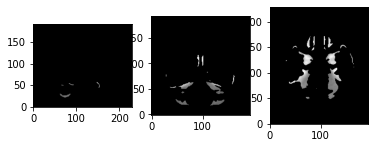

In [113]:
show_slices([corr_img_data_masked[51, :, :],

             corr_img_data_masked[:, 82, :],

             corr_img_data_masked[:, :, 54]])

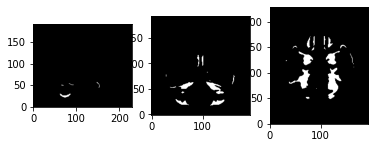

In [114]:
show_slices([GM_mask_data[51, :, :],

             GM_mask_data[:, 82, :],

             GM_mask_data[:, :, 54]])